<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/CNN/notebooks/07_03_Flower_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 自訂的輸入層及辨識層(Dense)

## 載入套件

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -fs /content/gdrive/My\ Drive /app
%cd /app/DL_Book/src

Mounted at /content/gdrive
/content/gdrive/My Drive/DL_Book/src


In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,fname='flower_photos',untar=False)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 3s 0us/step


## 步驟1：載入 Flower 資料

In [4]:
print(data_dir)
!ls /root/.keras/datasets
!cp /root/.keras/datasets/*.gz /app/DL_Book/
!tar xfz /app/DL_Book/flower_photos.tar.gz

/root/.keras/datasets/flower_photos
flower_photos
cp: cannot stat '/root/.keras/datasets/*.gz': No such file or directory


In [5]:
# 資料集來源：https://www.tensorflow.org/tutorials/load_data/images

# 參數設定
batch_size = 64
img_height = 224
img_width = 224
data_dir = './flower_photos/'

# 載入 Flower 訓練資料
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# 載入 Flower 驗證資料
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## 步驟2：進行特徵工程，將特徵縮放成(0, 1)之間

In [6]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## 顯示 ResNet152V2 完整的模型結構

In [7]:
base_model = ResNet152V2(weights='imagenet')
print(base_model.summary())

242761728/242745792 [==============================] - 3s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_____________________

In [8]:
len(base_model.layers)

566

## 步驟3：建立模型結構

In [9]:
# 預先訓練好的模型 -- ResNet152V2
base_model = ResNet152V2(weights='imagenet', include_top=False)
print(base_model.summary())

# 加上自訂的辨識層(Dense)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

# 指定自訂的輸入層及辨識層(Dense)
model = Model(inputs=base_model.input, outputs=predictions)

# 模型前段不需訓練了
for layer in base_model.layers:
    layer.trainable = False

# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

234561536/234545216 [==============================] - 3s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_____________________

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

## 步驟5：模型訓練

In [11]:
# 設定快取(cache)、prefetch，以增進訓練效率
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 模型訓練
history = model.fit(normalized_ds, validation_data = normalized_val_ds, epochs=5)

Epoch 1/5
46/46 [==============================] - 105s 1s/step - loss: 0.7696 - accuracy: 0.7309 - val_loss: 0.5024 - val_accuracy: 0.8406
Epoch 2/5
46/46 [==============================] - 53s 1s/step - loss: 0.3953 - accuracy: 0.8610 - val_loss: 0.4163 - val_accuracy: 0.8624
Epoch 3/5
46/46 [==============================] - 53s 1s/step - loss: 0.2989 - accuracy: 0.8992 - val_loss: 0.3840 - val_accuracy: 0.8692
Epoch 4/5
46/46 [==============================] - 53s 1s/step - loss: 0.2433 - accuracy: 0.9220 - val_loss: 0.3692 - val_accuracy: 0.8801
Epoch 5/5
46/46 [==============================] - 53s 1s/step - loss: 0.2045 - accuracy: 0.9387 - val_loss: 0.3626 - val_accuracy: 0.8801


## 步驟6：繪製訓練時準確率/損失函數的變化

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30906 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 28310 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30906 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text

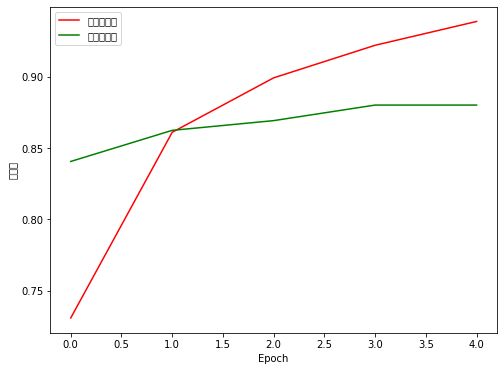

In [13]:
# 對訓練過程的準確率繪圖
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'g', label='驗證準確率')
plt.xlabel('Epoch')
plt.ylabel('準確率')
plt.legend()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25613 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25613 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35347 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32244 missing from current font.
  font.set_text

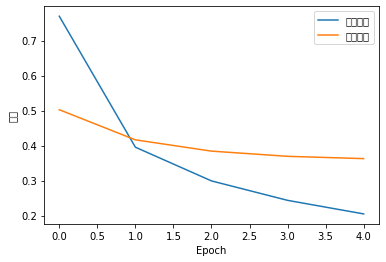

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='訓練損失')
plt.plot(history.history['val_loss'], label = '驗證損失')
plt.xlabel('Epoch')
plt.ylabel('損失')
plt.legend()

## 步驟7：預測

In [15]:
# 顯示辨識的類別
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [17]:
# 任選一張圖片，例如玫瑰
img_path = '../images_test/rose.png'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))

# 加一維，變成 (1, 224, 224, 3)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 預測
preds = model.predict(x)

# 顯示預測結果
y_pred = [round(i * 100, 2) for i in preds[0]]
print(f'預測機率(%)：{y_pred}')
print(f'預測類別：{class_names[np.argmax(preds)]}')

預測機率(%)：[0.01, 0.0, 99.67, 0.07, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0]
預測類別：roses


In [18]:
# 任選一張圖片，例如雛菊
img_path = '../images_test/daisy2.jpg'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))

# 加一維，變成 (1, 224, 224, 3)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 預測
preds = model.predict(x)

# 顯示預測結果
y_pred = [round(i * 100, 2) for i in preds[0]]
print(f'預測機率(%)：{y_pred}')
print(f'預測類別：{class_names[np.argmax(preds)]}')

預測機率(%)：[21.13, 67.45, 1.03, 4.99, 5.4, 0.0, 0.0, 0.0, 0.0, 0.0]
預測類別：dandelion
